# Exploring Convolutional Block Attention Modules

## Introduction

Attention is a critical component of human visual perception.  When we identify obejcts in the environment, we abstract from inessential elements, such as the background.  Therefore, it should be no surprise that incorporating attention in a neural network can boost performance.  In their paper "CBAM: Convolutional Block Attention Module," Woo, et al., propose a new attention module for CNNs.  The CBAM incorporates both spatial and channel attention.  The spatial module helps the network focus on the most relevent region of the image, while the channel attention module indentifies the most important features of the image.  The authors show that incorporating CBAMs into a residual neural network results in greater accuracy on Imagenet.  They also use a technique called gradient-weighted class activation mapping (Grad-CAM) to visualize how CBAM helps a network focus on the subject of an image.
\
\
In the first part of this report, I will be incorporating CBAMs into the ResNet I built for the previous report.  I will evaluate its performance and accuracy by comparing it to a baseline network.  The dataset I will be using is CIFAR-10.  In the second part, I will be looking inside the two networks.  I will be using the Grad-CAM technique to evaluate how well each network pays attention to the subject of the images.  I will also compute a few basic metrics of the weights of the convolution layers.  Finally, I try to visualize the convolution layers of each network.

## The Model

The basic structure of the baseline model is the same as the model I constructed for my previous report.  The network starts off with two convolutions to increase the channels to 32.  Then, there are 16 residual blocks.  After 4 blocks, the number of channels is doubled while the resolution is halved.  Finally, there is global average pooling and a linear layer before classification.  The CBAM model is the same as the baseline except that CBAM blocks are incorporated inside every residual block.  The CBAM has two components:  the spatial attention module and the channel attention module.  Both modules are constructed according to the paper.  In the spatial module, the input feature is averaged channel-wise and fed into an MLP.  The authors observe that max pooling and average pooling aggregate different aspects of the channel features.  Therefore, they use both.  Each resulting tensor is fed through the same MLP before being added together.  Then, the sigmoid function is applied.  In the spatial module, again both max pooling and average pooling are utilized.  This time, the averaging is done across all channels.  This results in two feature maps of the same height and width of the input to the module.  The maps are concatenated.  Then, a 1x1 convolution is used to combine the two maps into one.  This is fed into the sigmoid function to yield the spatial attention map. The authors consider many different arrangements for inserting the modules into the residual block.  They conclude that putting the channel module before the spatial module is the best.  Thus, the overal structure of the block is as follows:
\
\
output from previous block $\rightarrow$ channel module $\rightarrow$ spatial module $\rightarrow$ next block
\
\
Next, let's train the baseline and CBAM networks.

In [34]:
#Importing libraries

import torch
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import math
import pandas as pd
import random
import scipy.io
!pip install ttach
!pip install grad-cam
from pytorch_grad_cam import GradCAM
import cv2

In [5]:
#Import data

train_data, val_data = random_split(datasets.CIFAR10(root='./data', train=True, download=True,
                                                   transform=transforms.ToTensor()), [40000, 10000])
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

labels_dict = {'0': 'airplane',
              '1': 'automobile',
              '2': 'bird',
              '3': 'cat',
              '4': 'deer',
              '5': 'dog',
              '6': 'frog',
              '7': 'horse',
              '8': 'ship',
              '9': 'truck'}

Files already downloaded and verified
Files already downloaded and verified


In [6]:
#Setting batch size and constructing dataloaders

batch_size=128

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [7]:
#Functions for moving tensors/model to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [43]:
#Classification base

class ImageClassificationBase(nn.Module):   
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

#Channel module        

class ChannelModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.channels, self.channels // 4),
            nn.ReLU(),
            nn.Linear(self.channels // 4, channels)
            )
    def forward(self, x):
        avg_pool = F.avg_pool2d(x, (x.size(2),x.size(3)), stride=1)
        avg_pool_after_mlp = self.mlp(avg_pool)
        max_pool = F.max_pool2d(x, (x.size(2),x.size(3)), stride=1)
        max_pool_after_mlp = self.mlp(max_pool)
        avg_max_sum = avg_pool_after_mlp + max_pool_after_mlp
        channel_attention_map = F.sigmoid(avg_max_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x*channel_attention_map

#Spatial module    
    
class SpatialModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, 7, stride=1, padding=3)
    def forward(self, x):
        pooling = torch.cat((torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)
        conv = self.conv(pooling)
        spatial_attention_map = F.sigmoid(conv)
        return x*spatial_attention_map

#CBAM Block    

class CBAMBlock(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.channels = channels
        self.channel_mod = ChannelModule(self.channels)
        self.spatial_mod = SpatialModule()
    def forward(self, x):
        x = self.channel_mod(x)
        x = self.spatial_mod(x)
        return x

#ResBlock
    
class ResBlock(nn.Module):
    def __init__(self, channels_in, inc, stride, cbam_stat): #added cbam_stat: True if using CBAM
        super().__init__()
        self.channels_in = channels_in
        self.inc = inc
        self.stride = stride
        self.cbam_stat = cbam_stat
        self.bn1 = nn.BatchNorm2d(self.channels_in)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(self.channels_in, self.channels_in*self.inc, kernel_size=3, stride=self.stride, padding=1)
        self.bn2 = nn.BatchNorm2d(self.channels_in*inc)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.channels_in*inc, self.channels_in*self.inc, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.channels_in, self.channels_in*inc, kernel_size=1, stride=self.stride)
        self.cbam = CBAMBlock(self.channels_in*inc)
        self.channel_mlp = self.cbam.channel_mod.mlp
        self.spatial_conv = self.cbam.spatial_mod.conv
    def forward(self, x):
        residual = x
        if self.stride != 1 or self.inc != 1:
            residual = self.conv3(x)
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        if self.cbam_stat == True: #CBAM step
            out = self.cbam(out)
        return out + residual

#The network    

class ResNet(ImageClassificationBase):
    def __init__(self, cbam=False):
        super().__init__()
        self.cbam = cbam
        self.network = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(16,32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          ResBlock(32, 1, 2, self.cbam), #Images reduced to 16x16
          ResBlock(32, 1, 1, self.cbam), 
          ResBlock(32, 1, 1, self.cbam),
          ResBlock(32, 1, 1, self.cbam),
          ResBlock(32, 2, 2, self.cbam), #Images reduced to 8x8
          ResBlock(64, 1, 1, self.cbam), 
          ResBlock(64, 1, 1, self.cbam),
          ResBlock(64, 1, 1, self.cbam),
          ResBlock(64, 2, 2, self.cbam), #Images reduced to 4x4
          ResBlock(128, 1, 1, self.cbam),
          ResBlock(128, 1, 1, self.cbam),
          ResBlock(128, 1, 1, self.cbam),
          ResBlock(128, 2, 1, self.cbam), 
          ResBlock(256, 1, 1, self.cbam),
          ResBlock(256, 1, 1, self.cbam),
          ResBlock(256, 1, 1, self.cbam),
          nn.AvgPool2d(4),
          nn.Flatten(),
          nn.Linear(256,10))
        
    def forward(self, xb):
        return self.network(xb)

#Functions for computing validation and test accuracy   

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def test_accuracy(model, test_loader):
    corr = 0
    poss = 0
    incorrect = dict()
    confusion_matrix = np.zeros((10,10))
    model.eval()
    for batch in test_loader:
        images, labels = batch
        out = model(images)
        _, preds = torch.max(out, dim=1)
        t = torch.sum(preds == labels).item()
        poss += len(images)
        corr += t
        for y in range(len(preds)):
            if preds[y] != labels[y]:
                if str(labels[y].item()) not in incorrect.keys():
                    incorrect[str(labels[y].item())] = 1
                else:
                    incorrect[str(labels[y].item())] += 1
            confusion_matrix[preds[y].item()][labels[y].item()] += 1
    confusion_matrix = confusion_matrix.astype('int32')
    return corr/poss, incorrect, confusion_matrix

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
#Global params

num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
#Running baseline network

model_baseline = ResNet(cbam=False)
to_device(model_baseline, torch.device('cuda'))
baseline_results = fit(num_epochs, lr, model_baseline, train_dl, val_dl, opt_func)

In [ ]:
#Saving results of baseline network

import csv
keys = baseline_results[0].keys()
with open('baseline_results.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(baseline_results)

In [ ]:
#Saving weights of baseline network

torch.save(model_baseline.state_dict(), '/content/models/model_baseline')

In [ ]:
#Running CBAM network

model_cbam = ResNet(cbam=True)
to_device(model_cbam, torch.device('cuda'))
cbam_results = fit(num_epochs, lr, model_cbam, train_dl, val_dl, opt_func)

In [ ]:
#Saving CBAM results

keys = cbam_results[0].keys()
with open('cbam_results.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(cbam_results)

In [ ]:
#Saving CBAM weights

torch.save(model_cbam.state_dict(), '/content/models/model_cbam')

## The results

In [10]:
#Loading baseline weights

model_baseline = ResNet(cbam=False)
model_baseline.load_state_dict(torch.load(r'C:\Users\nomda\APPM_5720_REPORT 3\model_baseline_rev.pt'))
to_device(model_baseline, torch.device('cuda'))

ResNet(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResBlock(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2))
      (cbam): CBAMBlock(
        (channel_mod): ChannelModule(
          (mlp): Sequential(
            (0): Flatten(start_dim=1, en

In [11]:
#Loading cbam weights

model_cbam = ResNet(cbam=True)
model_cbam.load_state_dict(torch.load(r'C:\Users\nomda\APPM_5720_REPORT 3\model_cbam_rev.pt'))
to_device(model_cbam, torch.device('cuda'))

ResNet(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResBlock(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2))
      (cbam): CBAMBlock(
        (channel_mod): ChannelModule(
          (mlp): Sequential(
            (0): Flatten(start_dim=1, en

In [12]:
#Loading results

df1 = pd.read_csv(r"C:\Users\nomda\APPM_5720_REPORT 3\baseline_results_rev.csv")
df2 = pd.read_csv(r"C:\Users\nomda\APPM_5720_REPORT 3\cbam_results_rev.csv")

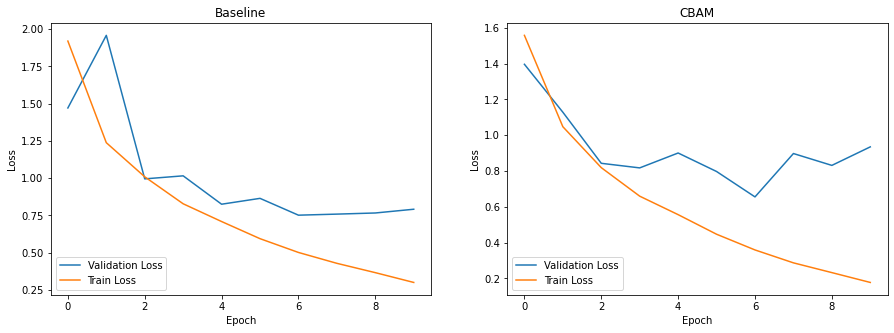

In [117]:
#Plotting validation and train loss

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(range(10), df1['val_loss'], label="Validation Loss")
axs[0].plot(df1['train_loss'], label="Train Loss")
axs[0].set_title('Baseline')
axs[0].legend(loc='lower left')
axs[1].plot(range(10), df2['val_loss'], label="Validation Loss")
axs[1].plot(df2['train_loss'], label="Train Loss")
axs[1].set_title('CBAM')
axs[1].legend(loc='lower left')


for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

Above, the validation and training losses are graphed for each network.  On previous runs of the networks, after 10 epochs, the validation loss began to increase and the validation accuracy remained stagnant.  Therefore, training was limited to 10 epochs.  The performance of each network on these metrics was comparable.

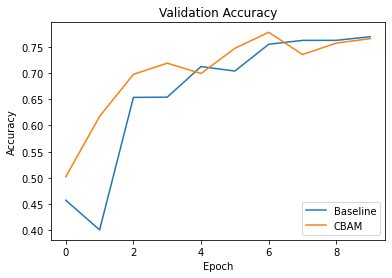

In [14]:
plt.plot(range(10), df1['val_acc'], label='Baseline')
plt.plot(df2['val_acc'], label='CBAM')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

Above, the validation accuracy for each network is plotted.  The baseline network was slower to converge.  But, both networks converge to almost the same validation accuracy after 10 epochs.

In [45]:
acc_baseline, incorrect_dict_baseline, confusion_matrix_baseline = test_accuracy(model_baseline, test_dl)
acc_cbam, incorrect_dict_cbam, confusion_matrix_cbam = test_accuracy(model_cbam, test_dl)

C:\Users\nomda\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [52]:
print('The baseline accuracy is', acc_baseline, 'and the CBAM accuracy is', acc_cbam)

The baseline accuracy is 0.7625 and the CBAM accuracy is 0.7571


Above are printed the accuracies for the two networks.  The baseline performed about 0.5% better than the CBAM network.

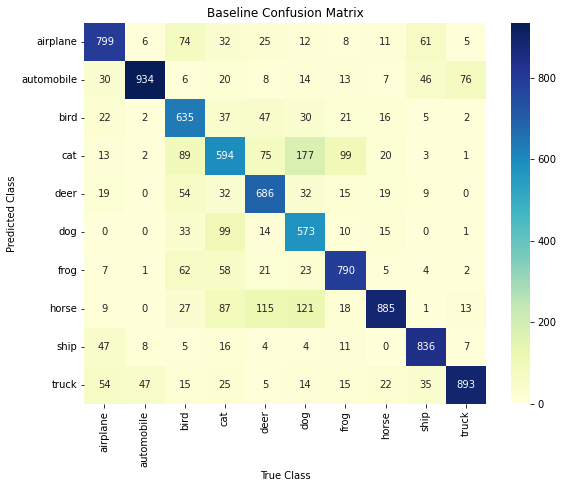

In [119]:
df_cm_baseline = pd.DataFrame(confusion_matrix_baseline, index = [i for i in labels_dict.values()],
                  columns = [i for i in labels_dict.values()])
plt.figure(figsize = (9,7))
sn.heatmap(df_cm_baseline, annot=True, cmap="YlGnBu", fmt='d').set(title='Baseline Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

The confusion matrix for the baseline network is displayed above.  The network achieved the highest accuracy for the automobile class.  It achieved the lowest accuracy for the dog class.  In particular, it identified 177 dogs as cats and 121 dogs as horses.  In general, the network seems to be very imprecise at classifying animals.  For example, although the network correctly identified 885 horses, it also identified 87 cats, 115 deer and 121 dogs as horses.  On the other hand, the network is very precise at classifying planes, automobiles, ships, and trucks.

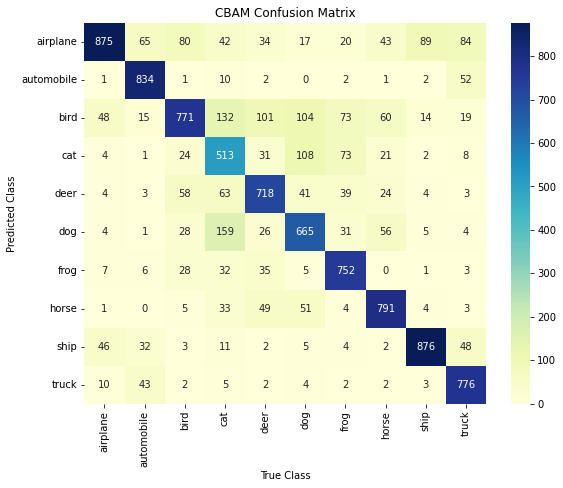

In [120]:
df_cm_cbam = pd.DataFrame(confusion_matrix_cbam, index = [i for i in labels_dict.values()],
                  columns = [i for i in labels_dict.values()])
plt.figure(figsize = (9,7))
sn.heatmap(df_cm_cbam, annot=True, cmap="YlGnBu", fmt='d').set(title='CBAM Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

The confusion matrix for the CBAM matrix is above.  The network achieved maximum accuracy for the airplane and ship classes.  It reached its lowest accuracy with the cat class.  The cat-dog confusion exists for the CBAM network as well.  While the baseline network confused more dogs for cats, the CBAM network confused more cats for dogs.  Overall, it does appear that the CBAM network also confuses many of the animal classes.  However, the classes it confuses the most are different from the baseline.  The CBAM network, unlike the baseline, is fairly precise with horses.  On the other hand, the CBAM network is very imprecise with birds.  In addition, it is interesting that the CBAM network is more imprecise with airplane classification than the baseline.
\
\
It is clear from the above results that while the baseline and CBAM networks have comparable overall accuracies, their confusion matricies are quite different.  In order to investigate further why these differences might exist, I turn to Grad-CAM analysis.

## Grad-CAM analysis

In their paper "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization," Selvaraju, et. al, introduce the gradient-weighted class activation mapping (Grad-CAM) technique.  This technique utilizes the gradients with respect to a target class going into the final convolution layer of a network to construct an activation map that highlights the regions of an image the network deems important for classification.  The authors argue that methods like Grad-CAM can help us understand why a network has come to a strange prediction and can identify dataset bias.  Most importantly, this visualization technique increases a network's interpretability and explainability.  This is especially apparent for attention modules.  The centeral motivation of attention modules is that they assist the network in focusing on the most important parts of an image.  Grad-CAM gives us the visualization tools to assess whether this is indeed true.
\
\
Below, I utilize Grad-CAM to put CBAM to the test.  From the confusion matricies above, I have identified a number of classes that the models have trouble with.  With the help of Grad-CAM, I hope to gain some insight into why these confusions are occurring.  In implementing Grad-CAM, I relied upon the Grad-CAM library and its associated github page (https://github.com/Cloud-CV/Grad-CAM).

In [20]:
def get_heatmap(img, layer, model):
    cam = GradCAM(model, layer, use_cuda=True)
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0,:]
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    timg = img[0].cpu().permute(1,2,0).numpy()
    out = 1*heatmap + timg
    out = out / np.max(out)
    out = np.uint8(255 * out)
    return out

def compare_incorrect_images(label, corr_model, incorr_model):
    correct_image = None
    
    for batch in test_dl:
        images, labels = batch
        for t in range(images.size()[0]):
            corr_model_label = torch.max(corr_model(images[t].unsqueeze(0)), dim=1)[1].item()
            incorr_model_label = torch.max(incorr_model(images[t].unsqueeze(0)), dim=1)[1].item()
            if labels[t] == label and corr_model_label == label and incorr_model_label != label:
                correct_image = images[t]
                break
        if correct_image != None:
            break
    model_incorr_heatmap = get_heatmap(images[t].unsqueeze(0), 
                                     incorr_model.network[21].conv2, incorr_model)
    model_corr_heatmap = get_heatmap(images[t].unsqueeze(0), 
                                     corr_model.network[21].conv2, corr_model)
    s = nn.Softmax(dim=0)
    corr_prob = s(corr_model(images[t].unsqueeze(0))[0])
    incorr_prob = s(incorr_model(images[t].unsqueeze(0))[0])
    corr_top_two = torch.topk(corr_prob,2)
    incorr_top_two = torch.topk(incorr_prob,2)
    corr_x_label = labels_dict[str(corr_top_two[1][0].item())] + ': ' + str(corr_top_two[0][0].item())[:5] + '  ' \
    + labels_dict[str(corr_top_two[1][1].item())] + ': ' + str(corr_top_two[0][1].item())[:5]
    incorr_x_label = labels_dict[str(incorr_top_two[1][0].item())] + ': ' + str(incorr_top_two[0][0].item())[:5] + '  ' \
    + labels_dict[str(incorr_top_two[1][1].item())] + ': ' + str(incorr_top_two[0][1].item())[:5]
    if corr_model == model_cbam:
        title1 = 'CBAM'
        title2 = 'Baseline'
    else:
        title2 = 'CBAM'
        title1 = 'Baseline'
    fig = plt.figure(figsize=(20, 25))
    a = fig.add_subplot(5, 5, 1)
    imgplot1 = plt.imshow(model_corr_heatmap)
    a.set_title(title1)
    a.set_xlabel(corr_x_label)
    b = fig.add_subplot(5, 5, 2)
    imgplot2 = plt.imshow(correct_image.cpu().permute(1,2,0))
    b.axis("off")
    b.set_title(labels_dict[str(label)])
    c = fig.add_subplot(5, 5, 3)
    imgplot2 = plt.imshow(model_incorr_heatmap)
    c.set_title(title2)
    c.set_xlabel(incorr_x_label)

In the figures below, the image on the left was correctly classified by the model listed above the image.  The image on the right was incorrectly classified by the model listed above the image.  In between the two is the original image.  Also listed below the images are the top two predictions made by the respective models along with the associated probabilities.  The last convolution layer of the respective networks was used to compute the activation maps.

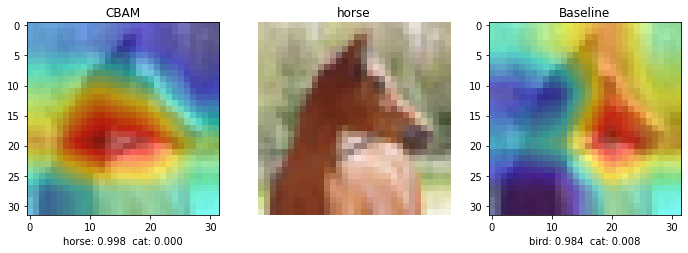

In [99]:
compare_incorrect_images(7, model_cbam, model_baseline)


Recall from above that the baseline network was very imprecise in classifying horses, meaning it has a tendency to classify things that aren't horses as horses.  Therefore, I thought it would be interesting to look at a few cases where the opposite has occurred, when the network misclassifies a horse.  We can see that the CBAM network is very confident (0.998) that the image is of a horse, while the baseline network is very confident that the image is of a bird.  It is interesting that, while the CBAM network doesn't focus too much on the head of the horse, it does look at more of the horse than the baseline network.  While it seems absurd that a horse would be mistaken for a bird, given that the baseline network only looked at the front of the head, it may seem a little more reasonable.  

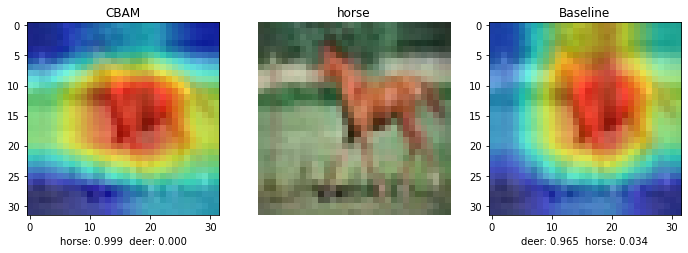

In [102]:
compare_incorrect_images(7, model_cbam, model_baseline)

Above is another horse example.  Again, both the CBAM and baseline networks are very confident in their classifications.  Unexpectedly, the baseline network seems to identify more of the hores than the CBAM network.  Therefore, it is reasonable to conclude that the baseline network misclassified the horse not because it couldn't identify the subject of the image, but perhaps because horses can be easily mistaken for deer (from a distance).

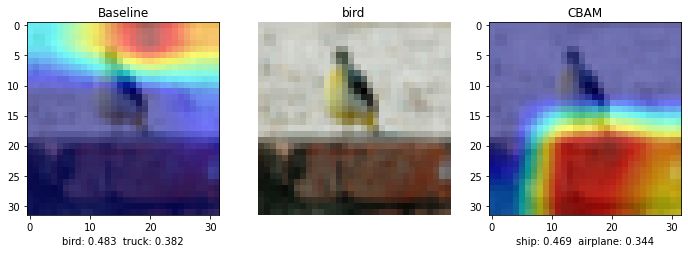

In [103]:
compare_incorrect_images(2, model_baseline, model_cbam)

The CBAM network seemed to be overly sensitive to classifying images as birds.  So, I thought it would be interesting to look at a few cases where the opposite occurs.  We can see above that both networks struggle in classifying the image.  The baseline network gets it correct, but it also thinks that it is a truck with a probability of 0.382.  In both cases, it is clear that the networks almost completely fail to identify the subject of the image.  The baseline happens to glimps some of the head of the bird, which may be why it was a little more successful.  The CBAM network appears to be intensely focused on the bottom right corner of the image.  The attention module has clearly failed here. 

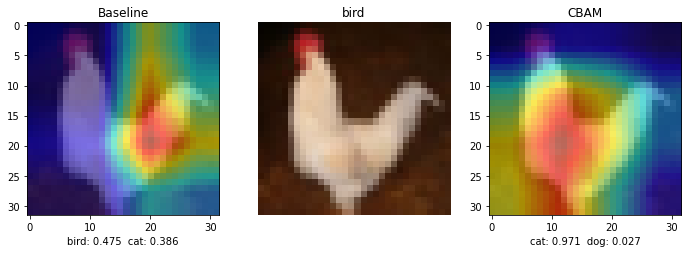

In [105]:
compare_incorrect_images(2, model_baseline, model_cbam)

Here is another bird example.  Strangely, the baseline gets the classification right, even though it sees less of the bird than the CBAM network.  The CBAM network notices the body of the bird, but not the head.  Perhaps if it had focused on the head, it would have classified the image correctly.  This appears to be a case where the attention module helped the network to better see the subject of the image but still failed to classify the image.

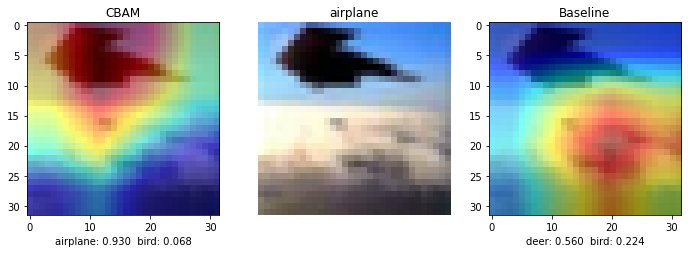

In [111]:
compare_incorrect_images(0, model_cbam, model_baseline)

While neither network struggled with the non-living classes as much as they did with the living classes, there still was a bit of confusion with the airplane class.  In addition, mistaking an airplane for a bird seems like a reasonable mistake.  So, I thought it would be a good idea to look at a few examples.  Here, the CBAM network beautifully captures the entire plane.  In addition, its second guess is 'bird,' which, again, is reasonable.  However, the baseline network completely fails to see the plane, instead focusing on the clouds below.  Given that it couldn't even find the subject of the image, it is perhaps a little more understandable that it classified the image as a deer.

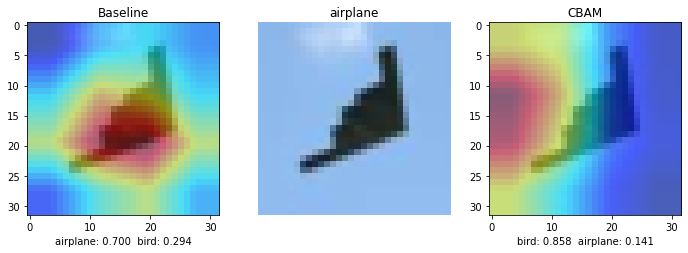

In [107]:
compare_incorrect_images(0, model_baseline, model_cbam)

Here, the opposite from the previous example has occurred.  The baseline has captured all of the plane.  In addition, its second guess is 'bird.' The CBAM network, however, completely misses the plane.  At least its second guess is airplane and its first is bird.  This is especially understandable as I believe a few humans might mistake this plane for a bird as well.

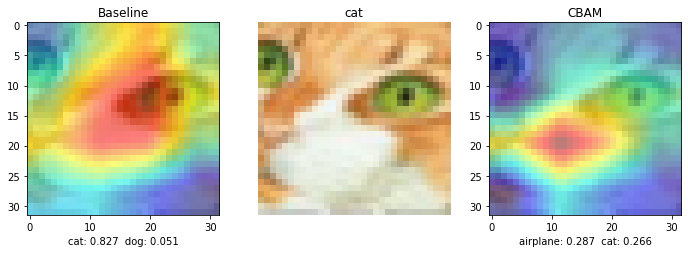

In [112]:
compare_incorrect_images(3, model_baseline, model_cbam)

As I noted before, the classic cat-dog confusion is present for both networks.  Therefore, I thought I would take a look at a few cat examples.  Here, the baseline is fairly confident that the image is of a cat, and its distant second guess is 'dog.'  Also, it seems to see perhaps 50% of the cat's face.  The CBAM network, on the other hand, seems to have no confidence in its classification, giving its top two guess just about 29% and 27% probability, respectively.  The network does seem to be focusing its attention intensely - but only at a tiny portion of the image.  Clearly, the attention modules were not helpful here.

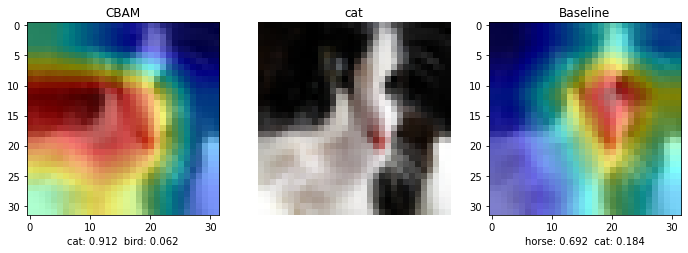

In [116]:
compare_incorrect_images(3, model_cbam, model_baseline)

Finally, here is one more cat example.  The CBAM network has succesfully identified most of the face of the cat, which may be why its classification is correct.  The baseline, however, only notices the region around the nose.  Strangely, its prediction is that the image is of a horse.  At least its second guess is 'cat.' 

## Looking inside the network

Working with Grad-CAM was very exciting, and it made me curious as to whether there were any other techniques for visualizing what is going on inside the networks.  I stumbled upon two great blog posts (https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573 and https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/) that give tutorials on how to visualize the weights of the convolutional layers. 
\
\
For each network, first the convolutional layers and their weights are extracted from the network.  Then each layer is applied to a sample image (the cat seen below).  The output for each application is a tensor with the same number of filters as the output of the convolutional layer.  These filters are averaged together in order to get a single representation for the layer.

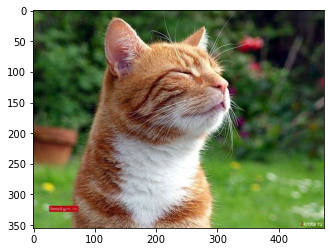

In [73]:
#importing and transforming image

img = cv2.imread(r"C:\Users\nomda\APPM 5720 - REPORT 3\cat1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
img = transform(img)
img = img.unsqueeze(0)

In [74]:
model_weights_cbam = []
conv_layers_cbam = [] 
model_children_cbam = list(model_cbam.children())

In [75]:
#Getting convolutional layers

counter = 0 

for i in range(len(model_children_cbam)):
    if type(model_children_cbam[i]) == nn.Conv2d:
        counter += 1
        model_weights_cbam.append(model_children_cbam[i].weight)
        conv_layers_cbam.append(model_children_cbam[i])
    elif type(model_children_cbam[i]) == nn.Sequential:
        for j in range(len(model_children_cbam[i])):
            for child in model_children_cbam[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights_cbam.append(child.weight)
                    conv_layers_cbam.append(child)

In [76]:
#Removing convolutions in attention blocks or in residual connections

remove_layers_cbam = []
for layer in conv_layers_cbam:
    if conv_layers_cbam.index(layer) % 4 == 3:
        remove_layers_cbam.append(layer)
for layer in conv_layers_cbam:
    if layer in remove_layers_cbam:
        conv_layers_cbam.remove(layer)

conv_layers_cbam.pop(14)
conv_layers_cbam.pop(25)
conv_layers_cbam.pop(-10)
conv_layers_cbam.insert(0, model_cbam.network[3])
conv_layers_cbam.insert(0, model_cbam.network[0])

In [77]:
#Applying layers to image

outputs_cbam = []
names_cbam = []
image_cbam = img.cuda()
for layer in conv_layers_cbam[0:]:
    image_cbam = layer(image_cbam)
    outputs_cbam.append(image_cbam)
    names_cbam.append(str(layer))

In [78]:
#Averaging filters

processed_cbam = []
for feature_map in outputs_cbam:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed_cbam.append(gray_scale.data.cpu().numpy())

In [79]:
model_weights_baseline = [] 
conv_layers_baseline = [] 
model_children_baseline = list(model_baseline.children())

In [80]:
#Getting convolutional layers

counter = 0 

for i in range(len(model_children_baseline)):
    if type(model_children_baseline[i]) == nn.Conv2d:
        counter += 1
        model_weights_baseline.append(model_children_baseline[i].weight)
        conv_layers_baseline.append(model_children_baseline[i])
    elif type(model_children_baseline[i]) == nn.Sequential:
        for j in range(len(model_children_baseline[i])):
            for child in model_children_baseline[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights_baseline.append(child.weight)
                    conv_layers_baseline.append(child)

In [81]:
#Removing convolutions in attention modules and residual connections

remove_layers_baseline = []
for layer in conv_layers_baseline:
    if conv_layers_baseline.index(layer) % 4 == 3:
        remove_layers_baseline.append(layer)
for layer in conv_layers_baseline:
    if layer in remove_layers_baseline:
        conv_layers_baseline.remove(layer)
        
conv_layers_baseline.pop(14)
conv_layers_baseline.pop(25)
conv_layers_baseline.pop(-10)
conv_layers_baseline.insert(0, model_baseline.network[3])
conv_layers_baseline.insert(0, model_baseline.network[0])

In [82]:
#Applying layers to image

outputs_baseline = []
names_baseline = []
image = img.cuda()
for layer in conv_layers_baseline[0:]:
    image = layer(image)
    outputs_baseline.append(image)
    names_baseline.append(str(layer))

In [83]:
#Averaging filters

processed_baseline = []
for feature_map in outputs_baseline:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed_baseline.append(gray_scale.data.cpu().numpy())

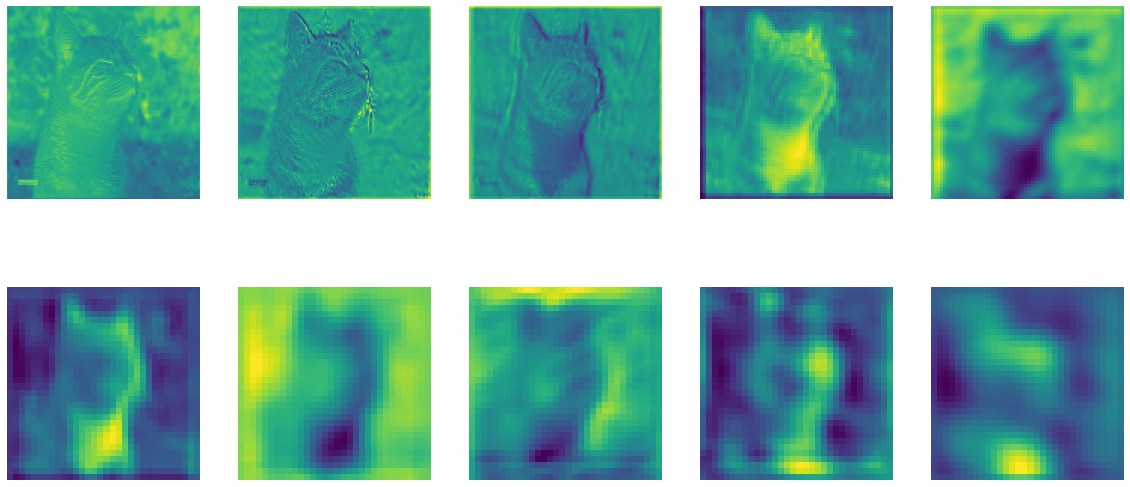

In [121]:
#Plotting baseline results

fig = plt.figure(figsize=(20, 25))
counter = 1
for i in range(len(processed_baseline)):
    if i % 5 == 0:
        a = fig.add_subplot(5, 5, counter)
        counter += 1
        imgplot = plt.imshow(processed_baseline[i])
        a.axis("off")


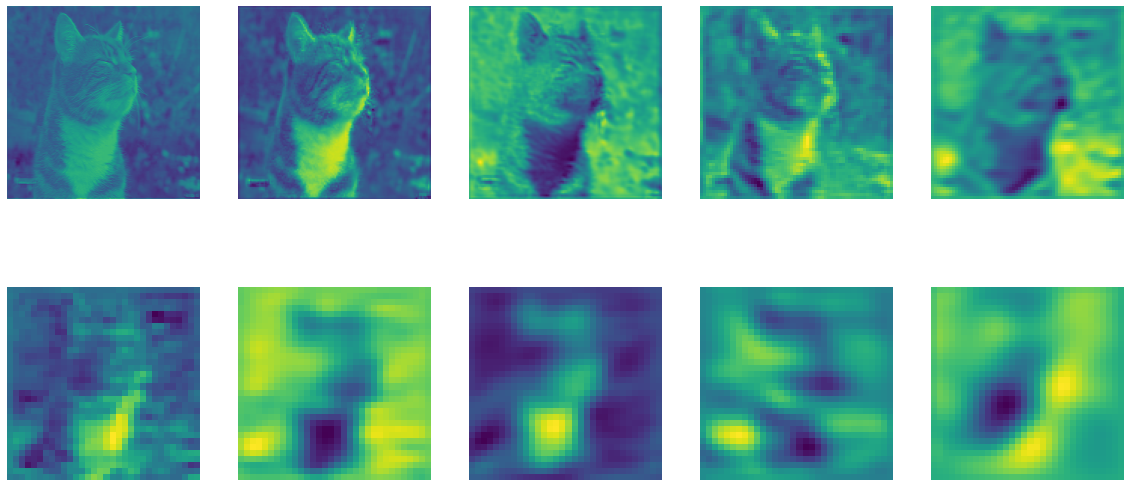

In [122]:
#Plotting CBAM results

fig = plt.figure(figsize=(20, 25))
counter = 1
for i in range(len(processed_cbam)):
    if i % 5 == 0:
        a = fig.add_subplot(5, 5, counter)
        counter += 1
        imgplot = plt.imshow(processed_cbam[i])
        a.axis("off")

The first set of images above are the results for the baseline network, while the second set is from the CBAM network.  Only the result for every fifth layer is shown.  It is interesting to see how different the results are.  The last few images are similar for both networks.  However, in all the other images, the cat is more visible in the CBAM results than in the baseline results.  The baseline filters tend to be more blurry, while the CBAM filters seem to retain more minute features of the cat.  Perhaps this is an indication of the effects of the attention modules in the CBAM network. 
\
\
Finally, since I now have the weights for each convolution layer, I thought it would be interesting to compute a few basic statistics.

In [89]:
#Computing mean value of weights for each layer and network

mean_weights_cbam = []
for layer in conv_layers_cbam:
    mean_weights_cbam.append(torch.mean(layer.weight).item())
    
mean_weights_baseline = []
for layer in conv_layers_baseline:
    mean_weights_baseline.append(torch.mean(layer.weight).item())

In [123]:
#Computing variance of weights for each layer and network

std_weights_cbam = []
for layer in conv_layers_cbam:
    std_weights_cbam.append(torch.var(layer.weight).item())
    
std_weights_baseline = []
for layer in conv_layers_baseline:
    std_weights_baseline.append(torch.var(layer.weight).item())

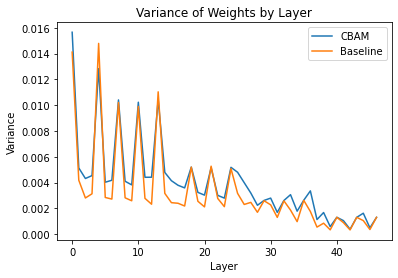

In [125]:
#Plotting results

plt.plot(range(len(std_weights_cbam)), std_weights_cbam, label='CBAM')
plt.plot(std_weights_baseline, label='Baseline')
plt.legend(loc='best')
plt.title('Variance of Weights by Layer')
plt.xlabel("Layer")
plt.ylabel("Variance")
plt.show()


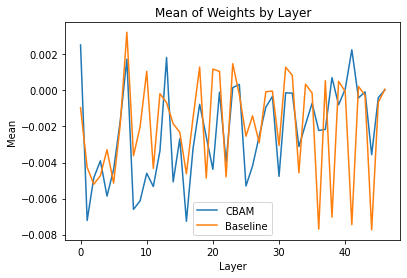

In [126]:
#Plotting results

plt.plot(range(len(mean_weights_cbam)), mean_weights_cbam, label='CBAM')
plt.plot(mean_weights_baseline, label='Baseline')
plt.legend(loc='best')
plt.title('Mean of Weights by Layer')
plt.xlabel("Layer")
plt.ylabel("Mean")
plt.show()

Above, the mean and variance of the weights by layer for each network are plotted. It is interesting to see the periodicity of both measures.  In addition, it is strange the way the variance of the weights decays layer by layer.  The weights are all centered around 0, and the variance is relatively small.  Overall, there doesn't appear to be too much of a difference between the two networks.  However, the amplitude of the oscillations of both measures is greater for the baseline network than for the CBAM network.  Perhaps this is a reflection of the way the attention modules help the CBAM network focus.  It might be the case that the more a network is able to focus on the subjects of images, the less the weights of the layers vary.

## Conclusions

In this report, we saw how the CBAM and baseline networks had comparable accuracies yet had remarkably different classification biases.  As the Grad-CAM analysis revealed, it is not entirely clear whether the attention modules of the CBAM network helped the network identify the subject of the images.  As indicated by the confusion matricies, its imprecision in classification was different in character from baseline but still comparable in magnitude.  We saw via a number of examples how sometimes the CBAM network was better while other times the baseline was better.  However, visualizing the weights of the two networks did bring out a few differences.  The results for the CBAM network were sharper and more distinct deeper in the network than they were for the baseline.  Finally, we saw how the weights of the CBAM network varied slightly less than the weights of the baseline network.  
\
\
There are a number of reasons why my results were not as clear as those in the CBAM paper.  The first is that the authors of the paper implemented CBAM in bigger networks.  The second is the authors worked with Imagenet, a much larger and higher quality dataset.  Given that they were only able to achieve a few extra accuracy points, maybe it shouldn't be surprising that my results were not as definitive.  If I had more time and resources, I would certainly like to explore integrating CBAMs into larger networks.